# Motivation 

Purpose of this training task is to predict next 3 days of claims per each city.

# Libraries

In [1]:
from itertools import product

import lightning.pytorch as pl
from lightning.pytorch.callbacks import EarlyStopping, LearningRateMonitor
from lightning.pytorch.tuner import Tuner
from lightning.pytorch.loggers import TensorBoardLogger

import os

import pandas as pd

from pytorch_forecasting import Baseline, TemporalFusionTransformer, TimeSeriesDataSet
from pytorch_forecasting.data import TorchNormalizer, GroupNormalizer
from pytorch_forecasting.metrics import MAE, QuantileLoss

from sklearn.model_selection import train_test_split

import torch

# Add the ../src directory to the Python path
import sys
sys.path.append(os.path.abspath(os.path.join('..')))

from src import (
    adjust_column_names)

# Data Import

In [2]:
source_data = pd.read_csv(
    os.path.join('..', 'data', 'insurance_data_sample.csv'),
    sep=',',
    encoding='utf-8',
    parse_dates=['Date'],
    dtype={'Phone': str})

# Preprocess

In [3]:
prep_data = source_data.copy()

## Adjust column names

In [4]:
prep_data = adjust_column_names(prep_data)

## Calculate monthly claims

In [5]:
prep_data = prep_data\
    .groupby(['date', 'city'])\
    .agg(
        sum_of_claims=pd.NamedAgg('claim_amount', 'sum'))\
    .reset_index()

## Calculate date features

In [6]:
prep_data.loc[:, 'day_of_week'] = prep_data.loc[:, 'date'].dt.dayofweek.astype(str)
prep_data.loc[:, 'day'] = prep_data.loc[:, 'date'].dt.day.astype(str)
prep_data.loc[:, 'month'] = prep_data.loc[:, 'date'].dt.month.astype(str)
prep_data.loc[:, 'year'] = prep_data.loc[:, 'date'].dt.year.astype(str)
prep_data.loc[:, 'yyyymm'] = prep_data.loc[:, 'date'].dt.strftime('%Y%m')

## Add time index

In [7]:
prep_data.loc[:, 'temp_1'] = (prep_data.loc[:, 'date'] - prep_data.loc[:, 'date'].min())

prep_data.loc[:, 'time_idx'] = (prep_data.loc[:, 'temp_1'].dt.days) + 1

prep_data.drop(['temp_1'], axis=1, inplace=True)

# Analysis

## Create datasets

In [339]:
max_prediction_length = 12
max_encoder_length = 24

all_idx = prep_data.time_idx.unique()
train_idx, test_idx = train_test_split(all_idx, test_size=0.15, shuffle=False)
train_idx, val_idx = train_test_split(train_idx, test_size=0.15, shuffle=False)

all_dataset = TimeSeriesDataSet(
    prep_data,
    time_idx='time_idx',
    target='sum_of_claims',
    group_ids=['city'],
    min_encoder_length=max_encoder_length,
    max_encoder_length=max_encoder_length,
    min_prediction_length=max_prediction_length,
    max_prediction_length=max_prediction_length,
    static_categoricals=['city'],
    static_reals=[],
    time_varying_known_categoricals=['year', 'month', 'day', 'day_of_week'],
    time_varying_known_reals=['time_idx'],
    time_varying_unknown_categoricals=[],
    time_varying_unknown_reals=['sum_of_claims'],
    target_normalizer=TorchNormalizer(),
    add_relative_time_idx=False,
    add_target_scales=False,
    add_encoder_length=False,
    allow_missing_timesteps=True)

train_dataset = TimeSeriesDataSet.from_dataset(
    all_dataset,
    prep_data.query('time_idx in @train_idx'),
    stop_randomization=True)

val_dataset = TimeSeriesDataSet.from_dataset(
    all_dataset,
    prep_data.query('time_idx in @val_idx'),
    stop_randomization=True)

test_dataset = TimeSeriesDataSet.from_dataset(
    all_dataset,
    prep_data.query('time_idx in @test_idx'),
    stop_randomization=True)\

batch_size = 128
train_dataloader = train_dataset.to_dataloader(train=True, batch_size=batch_size, num_workers=4)
val_dataloader = val_dataset.to_dataloader(train=False, batch_size=batch_size, num_workers=4)
test_dataloader = test_dataset.to_dataloader(train=False, batch_size=len(test_dataset), num_workers=4)

## Baseline model

In [340]:
baseline_model = Baseline()
baseline_predictions = baseline_model.predict(test_dataloader, return_y=True)
mae_baseline = MAE()(baseline_predictions.output, baseline_predictions.y).item()

print(f'Mean absolute error of baseline model: {mae_baseline}')

/opt/conda/lib/python3.10/site-packages/lightning/pytorch/utilities/parsing.py:199: Attribute 'loss' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss'])`.
/opt/conda/lib/python3.10/site-packages/lightning/pytorch/utilities/parsing.py:199: Attribute 'logging_metrics' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['logging_metrics'])`.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Mean absolute error of baseline model: 3384.442138671875


## Temporal fusion transformer model

In [341]:
HIDDEN_SIZE=16
ATTENTION_HEAD_SIZE=4
DROPOUT_RATE=0.1
HIDDEN_CONTINOUS_SIZE=16

### Training

In [342]:
# configure network and trainer
early_stop_callback = EarlyStopping(monitor='val_loss', min_delta=1e-4, patience=10, verbose=False, mode='min')
lr_logger = LearningRateMonitor()
logger = TensorBoardLogger("lightning_logs")

trainer = pl.Trainer(
    max_epochs=1000,
    accelerator='gpu',
    enable_model_summary=True,
    gradient_clip_val=0.25,
    callbacks=[lr_logger, early_stop_callback],
    logger=logger)

tft = TemporalFusionTransformer.from_dataset(
    train_dataset,
    output_size=1,
    learning_rate=0.005,
    hidden_size=HIDDEN_SIZE,
    attention_head_size=ATTENTION_HEAD_SIZE,
    dropout=DROPOUT_RATE,
    hidden_continuous_size=HIDDEN_CONTINOUS_SIZE,
    loss=MAE(),
    log_interval=10,
    optimizer='Adam',
    reduce_on_plateau_patience=4)
print(f"Number of parameters in network: {tft.size()/1e3:.1f}k")

# fit network
trainer.fit(
    tft,
    train_dataloaders=train_dataloader,
    val_dataloaders=val_dataloader)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

   | Name                               | Type                            | Params
----------------------------------------------------------------------------------------
0  | loss                               | MAE                             | 0     
1  | logging_metrics                    | ModuleList                      | 0     
2  | input_embeddings                   | MultiEmbedding                  | 474   
3  | prescalers                         | ModuleDict                      | 64    
4  | static_variable_selection          | VariableSelectionNetwork        | 48    
5  | encoder_variable_selection         | VariableSelectionNetwork        | 3.1 K 
6  | decoder_variable_selection         | VariableSelectionNetwork        | 1.7 K 
7  | static_context_variable_selection  | GatedResid

Number of parameters in network: 19.1k


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/opt/conda/lib/python3.10/site-packages/lightning/pytorch/loops/fit_loop.py:298: The number of training batches (14) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

In [343]:
# calcualte mean absolute error on validation set
tft_predictions = tft.predict(test_dataloader, return_y=True, trainer_kwargs=dict(accelerator='gpu'))
mae_tft = MAE()(tft_predictions.output, tft_predictions.y).item()

print(f'mean absolute error of tft model: {mae_tft}')

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


mean absolute error of tft model: 2907.64453125


# Investigate

In [349]:
for batch in test_dataloader:
    x, y = batch

    break

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


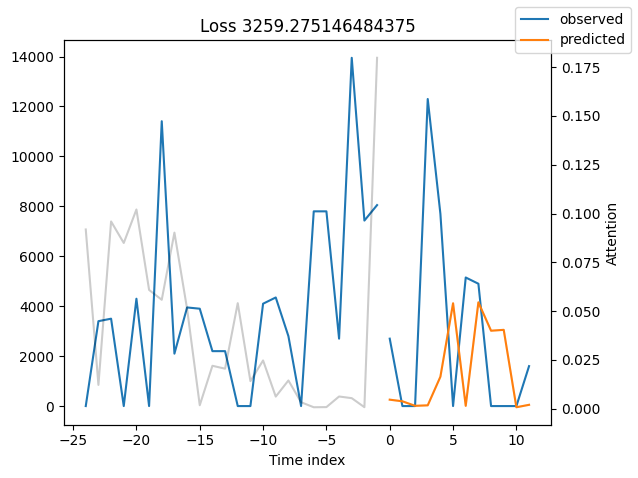

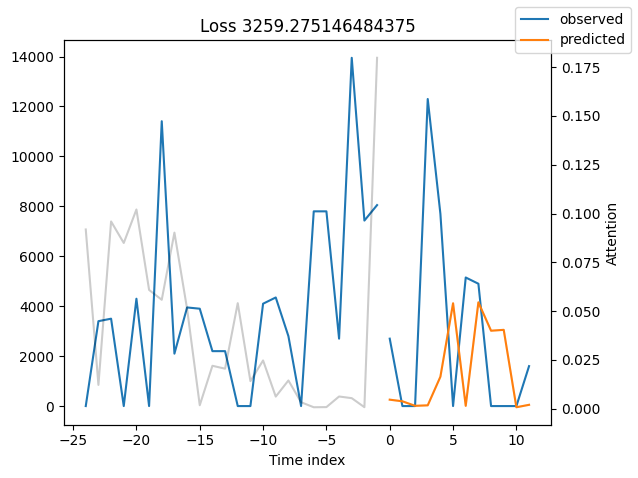

In [360]:
raw_predictions = tft.predict(test_dataloader, mode='raw', return_x=True)
tft.plot_prediction(raw_predictions.x, raw_predictions.output, idx=320, add_loss_to_title=True)

{'attention': <Figure size 640x480 with 1 Axes>,
 'static_variables': <Figure size 700x225 with 1 Axes>,
 'encoder_variables': <Figure size 700x350 with 1 Axes>,
 'decoder_variables': <Figure size 700x325 with 1 Axes>}

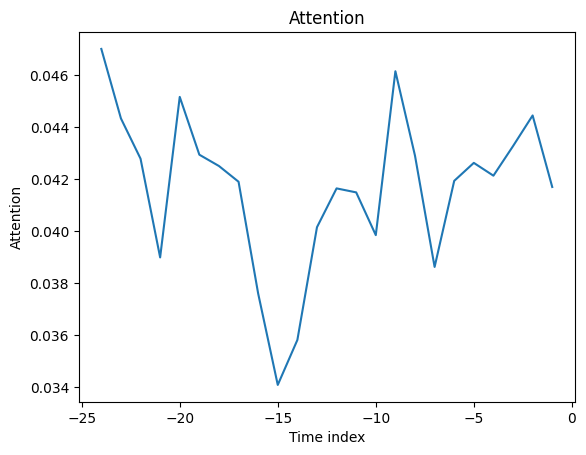

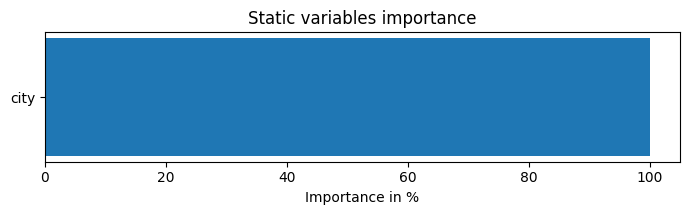

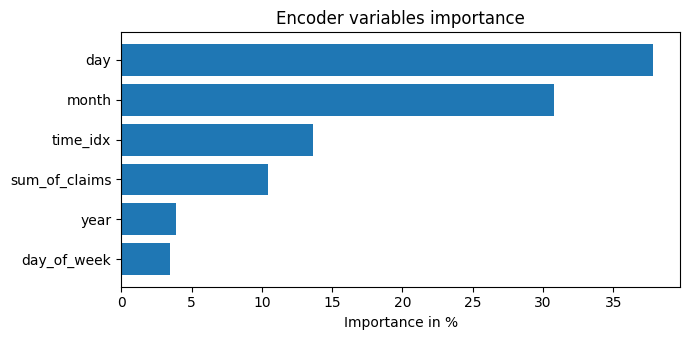

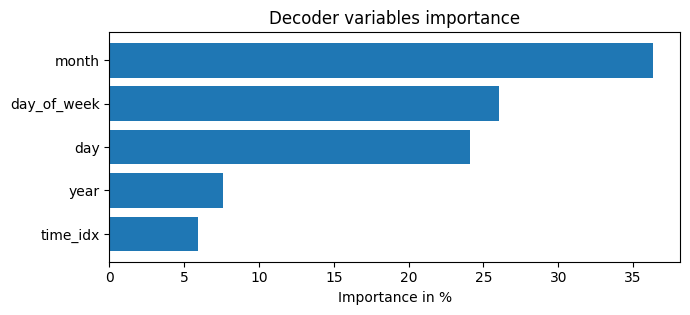

In [361]:
interpretation = tft.interpret_output(raw_predictions.output, reduction="mean")
tft.plot_interpretation(interpretation)